# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Your code here :

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [4]:
# Show the first 10 words with their index
print(list(tokenizer.word_index.items())[:10])

[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('my', 5), ('i', 6), ('in', 7), ('that', 8), ('thy', 9), ('thou', 10)]


Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [5]:
# Your code here :
total_words = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {total_words}")

Vocabulary size: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [6]:
# Your code here :
input_sequences = []

for line in corpus:
    # Convert each line into a sequence of integers
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        # Generate n-grams for each sequence
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Print first few sequences for verification
print(input_sequences[:5])  # Show the first 5 n-gram sequences

[[3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118, 1376]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [7]:
# Your code here :
# Find the length of the longest sequence
max_sequence_len = max([len(seq) for seq in input_sequences])

print(f"Maximum sequence length: {max_sequence_len}")

Maximum sequence length: 11


In [8]:
# Pad sequences to the same length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

print(f"Padded input shape: {input_sequences.shape}")

Padded input shape: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [9]:
# Your code here :
# Split sequences into predictors (X) and labels (y)
X = input_sequences[:, :-1]  # All columns except the last one
y = input_sequences[:, -1]   # The last column only

print(f"Shape of predictors (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")

Shape of predictors (X): (15484, 10)
Shape of labels (y): (15484,)


In [10]:
print(f"Shape of predictors (X): {X}")
print(f"Shape of labels (y): {y}")

Shape of predictors (X): [[   0    0    0 ...    0    0    3]
 [   0    0    0 ...    0    3    2]
 [   0    0    0 ...    3    2  313]
 ...
 [   0    0    0 ... 3373  493  493]
 [   0    0    0 ...  493  493 3374]
 [   0    0    0 ...  493 3374   14]]
Shape of labels (y): [   2  313 1375 ... 3374   14   15]


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [11]:
# Your code here :
# One-hot encode the labels (y)
y = ku.to_categorical(y, num_classes=total_words)

print(f"Shape of one-hot encoded labels: {y.shape}")

Shape of one-hot encoded labels: (15484, 3375)


In [27]:
print(y)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

In [13]:
model = Sequential([

    # Your code here :

    # Embedding layer
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),

    # Bidirectional LSTM layer
    Bidirectional(LSTM(150, return_sequences=True)),

    # Dropout layer
    Dropout(0.2),

    # Second LSTM layer
    LSTM(100),

    # Dense layer with ReLU activation
    Dense(total_words // 2, activation='relu', kernel_regularizer=l2(0.01)),

    # Output Dense layer with Softmax activation
    Dense(total_words, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
model.summary()  # Print the model structure

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [15]:
# Your code here :

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [16]:
# Your code here :
model.summary()  # Print the model structure

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Build the model with the specified input shape
model.build(input_shape=(None, max_sequence_len - 1))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │         337,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1687)                │         170,387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3375)                │       5,697,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [18]:
# Your code here :

# Train the model
history = model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.0228 - loss: 7.3423
Epoch 2/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0242 - loss: 6.5066
Epoch 3/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0249 - loss: 6.4016
Epoch 4/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0288 - loss: 6.2974
Epoch 5/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0357 - loss: 6.1953
Epoch 6/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0363 - loss: 6.1568
Epoch 7/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0411 - loss: 6.0569
Epoch 8/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0430 - loss: 5.9953
Epoch 9/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0422 - loss: 5.9172
Epoch 10/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0458 - loss: 5.8735
Epoch 11/200
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0496 - loss: 5.7901
Epoch 12/200
484/484 ━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

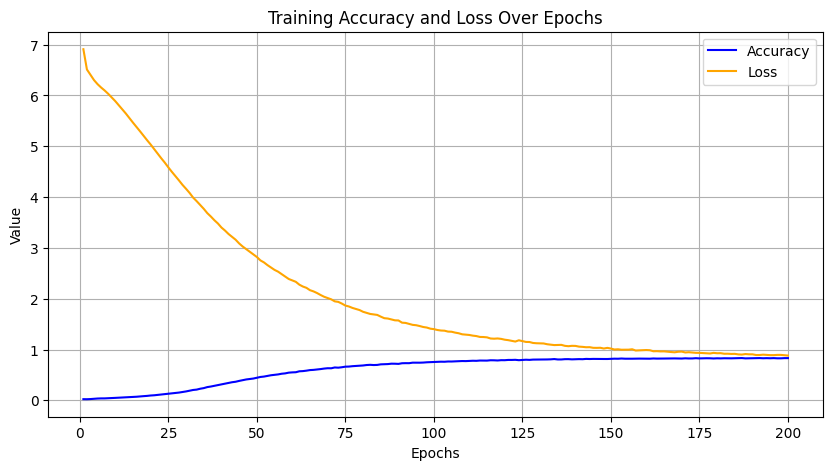

In [19]:
import matplotlib.pyplot as plt

# Get the training accuracy and loss from the history
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot accuracy and loss together
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', color='blue')
plt.plot(epochs, loss, label='Loss', color='orange')
plt.title('Training Accuracy and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


In [21]:
# Evaluate the model on the training data
metrics = model.evaluate(X, y, verbose=1)

# Print the results
for metric_name, metric_value in zip(model.metrics_names, metrics):
    print(f"{metric_name}: {metric_value:.4f}")

484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8625 - loss: 0.7465
loss: 0.7374
compile_metrics: 0.8632


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [22]:
# Your code here :

# Seed text and number of words to generate
seed_text = "love is"
next_words = 20  # Adjust the number of words to generate

for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]  # Get the index of the highest probability

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("Generated text:")
print(seed_text)


Generated text:
love is too young to know what conscience is you so rare you hold it alone and die mine eye give me


In [24]:
# Second Test:

# Seed text and number of words to generate
seed_text = "Sacrifice"
next_words = 10  # Adjust the number of words to generate

for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]  # Get the index of the highest probability

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("Generated text:")
print(seed_text)

Generated text:
Sacrifice that i have frequent been with unknown minds lend the


In [25]:
# Third Test:

# Seed text and number of words to generate
seed_text = "I am dying"
next_words = 5  # Adjust the number of words to generate

for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]  # Get the index of the highest probability

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("Generated text:")
print(seed_text)

Generated text:
I am dying how i do not then


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [29]:
# Your code here :
# Prompt the user for a seed text and number of words to generate
seed_text = input("Enter your seed text: ")
next_words = int(input("Enter the number of words to generate: "))

# Generate text
for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("\nGenerated text:")
print(seed_text)

Enter your seed text: My heart
Enter the number of words to generate: 10

Generated text:
My heart doth plead that thou in him dost lie will bear


Experiment with at least 3 different seed_text strings and see what happens!

In [30]:
# Second Test :

# Prompt the user for a seed text and number of words to generate
seed_text = input("Enter your seed text: ")
next_words = int(input("Enter the number of words to generate: "))

# Generate text
for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("\nGenerated text:")
print(seed_text)

Enter your seed text: the light of the moon
Enter the number of words to generate: 7

Generated text:
the light of the moon of things ill ill well ' grew


In [31]:
# Third Test :

# Prompt the user for a seed text and number of words to generate
seed_text = input("Enter your seed text: ")
next_words = int(input("Enter the number of words to generate: "))

# Generate text
for _ in range(next_words):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the tokenized sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Convert index to word
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

# Print the generated text
print("\nGenerated text:")
print(seed_text)

Enter your seed text: Bloody night
Enter the number of words to generate: 10

Generated text:
Bloody night o'er dearest not full of ill ' shall have your
